In [1]:
import string
import re
import nltk
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt
import operator

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
!pip install -U spacy
!pip install -U spacy-lookups-data
!python -m spacy download es_core_news_sm

Requirement already up-to-date: spacy in /home/javier/anaconda3/lib/python3.6/site-packages (2.2.3)
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: spacy-lookups-data in /home/javier/anaconda3/lib/python3.6/site-packages (0.2.0)
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [4]:
# https://github.com/pablodms/spacy-spanish-lemmatizer
!pip install es-lemmatizer

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import spacy
nlp = spacy.load('es_core_news_sm')

In [6]:
# rule-based lemmatization
from es_lemmatizer import lemmatize
nlp.add_pipe(lemmatize, after='tagger')

## read data
### chile+bolivia+ecuador

In [7]:
f = open("chile.txt", "r") 
chile=f.read()

In [8]:
g = open("bolivia.txt", "r") 
bolivia=g.read()

In [9]:
h = open("ecuador.txt", "r") 
ecuador=h.read()

In [10]:
chile[:1000]

'Capítulo I\n\n     BASES DE LA INSTITUCIONALIDAD\n\n\n\n\n     Artículo 1°.- Las personas nacen libres e iguales en dignidad y derechos.\n     La familia es el núcleo fundamental de la sociedad.\n     El Estado reconoce y ampara a los grupos intermedios a través de los cuales se organiza y estructura la sociedad y les garantiza la adecuada autonomía para cumplir sus propios fines específicos.\n     El Estado está al servicio de la persona humana y su finalidad es promover el bien común, para lo cual debe contribuir a crear las condiciones sociales que permitan a todos y a cada uno de los integrantes de la comunidad nacional su mayor realización espiritual y material posible, con pleno respeto a los derechos y garantías que esta Constitución establece.\n     Es deber del Estado resguardar la seguridad nacional, dar protección a la población y a la familia, propender al fortalecimiento de ésta, promover la integración armónica de todos los sectores de la Nación y asegurar el derecho de 

In [11]:
bolivia[:1000]

'PREÁMBULO\n\nEn tiempos inmemoriales se erigieron montañas, se desplazaron ríos, se formaron lagos. Nuestra amazonia, nuestro chaco, nuestro altiplano y nuestros llanos y valles se cubrieron de verdores y flores. Poblamos esta sagrada Madre Tierra con rostros diferentes, y comprendimos desde entonces la pluralidad vigente de todas las cosas y nuestra diversidad como seres y culturas. Así conformamos nuestros pueblos, y jamás comprendimos el racismo hasta que lo sufrimos desde los funestos tiempos de la colonia.\n\nEl pueblo boliviano, de composición plural, desde la profundidad de la historia, inspirado en las luchas del pasado, en la sublevación indígena anticolonial, en la independencia, en las luchas populares de liberación, en las marchas indígenas, sociales y sindicales, en las guerras del agua y de octubre, en las luchas por la tierra y territorio, y con la memoria de nuestros mártires, construimos un nuevo Estado.\n\nUn Estado basado en el respeto e igualdad entre todos, con pr

In [12]:
ecuador[:1000]

'Preámbulo\n\nNosotras y nosotros, el pueblo soberano del Ecuador\n\nRECONOCIENDO nuestras raíces milenarias, forjadas por mujeres y hombres de distintos pueblos,\n\nCELEBRANDO a la naturaleza, la Pacha Mama, de la que somos parte y que es vital para nuestra existencia,\n\nINVOCANDO el nombre de Dios y reconociendo nuestras diversas formas de religiosidad y espiritualidad,\n\nAPELANDO a la sabiduría de todas las culturas que nos enriquecen como sociedad,\n\nCOMO HEREDEROS de las luchas sociales de liberación frente a todas las formas de dominación y colonialismo,\n\nY con un profundo compromiso con el presente y el futuro,\n\nDecidimos construir\n\nUna nueva forma de convivencia ciudadana, en diversidad y armonía con la naturaleza, para alcanzar el buen vivir, el sumak kawsay;\n\nUna sociedad que respeta, en todas sus dimensiones, la dignidad de las personas y las colectividades;\n\nUn país democrático, comprometido con la integración latinoamericana —sueño de Bolívar y Alfaro-, la paz

In [13]:
def clean(text,tag):
    text=text.split('\n') #line marker
    text=[s.strip() for s in text if len(s)>0] #blank strings and remove blank characters
    text=[s.lower() for s in text] #lower strings
    text=[nlp(s) for s in text] 
    if tag=='noun':
        text=[[token.lemma_ for token in s if token.pos_=='NOUN'] for s in text]#if token.tag_=='NN' or token.tag_=='NNS' or token.tag_=='JJ'] for s in text]
    elif tag=='noun_adj':
        text=[[token.lemma_ for token in s if token.pos_=='NOUN' or token.pos_=='ADJ'] for s in text]
    elif tag=='noun_verb':
        text=[[token.lemma_ for token in s if token.pos_=='NOUN' or token.pos_=='VERB'] for s in text]
    elif tag=='verb':
        text=[[token.lemma_ for token in s if token.pos_=='VERB'] for s in text]
    elif tag=='all':
        text=[[token.lemma_ for token in s if token.pos_=='NOUN' or token.pos_=='ADJ' or token.pos_=='VERB'] for s in text]
    #table = str.maketrans({key: None for key in string.punctuation}) #remove punctuation
    #text=[s.translate(table) for s in text]
    #text=[s.split(' ') for s in text] #word-tokenization
    #text=[[w for w in s if w not in ['artículo','capítulo']] for s in text] #remove two meaningless words
    #pattern = re.compile('\W')
    #text=[[re.sub(pattern, '', w) for w in s] for s in text] #remove non-alphanumeric characters from strings
    #text=[[w for w in s if not w.isdigit()] for s in text] #remove digits
    text=[[w for w in s if w not in spacy.lang.es.stop_words.STOP_WORDS.union(set(stopwords.words('spanish')))] for s in text] #remove stopwords
    roman_numerals=["i.", "ii.", "iii.", "iv.", "v.", "vi.", "vii.", "viii.", "ix.","x.", "xx.", "xxx.", "xl.", "l.", "lx.", "lxx.", "lxxx.", "xc.","c.", "cc.", "ccc.", "cd.", "d.", "dc.", "dcc.", "dccc.", "cm.","m.", "mm.", "mmm."]
    text=[[w for w in s if w.upper() not in roman_numerals] for s in text]
    text=[s for s in text if len(s)>1] #remove shorter sentences

    return text

In [14]:
clean(chile,'noun_verb')[:10]

[['base', 'institucionalidad'],
 ['persona', 'nacer', 'dignidad', 'derecho'],
 ['familia', 'núcleo', 'sociedad'],
 ['reconocer',
  'amparar',
  'grupo',
  'organizar',
  'estructurar',
  'sociedad',
  'garantizar',
  'autonomía',
  'cumplir'],
 ['servicio',
  'persona',
  'finalidad',
  'promover',
  'contribuir',
  'crear',
  'condición',
  'permitir',
  'integrante',
  'comunidad',
  'realización',
  'material',
  'respeto',
  'derecho',
  'garantía',
  'constitución',
  'establecer'],
 ['deber',
  'resguardar',
  'seguridad',
  'protección',
  'población',
  'familia',
  'propender',
  'fortalecimiento',
  'promover',
  'integración',
  'sector',
  'nación',
  'asegurar',
  'derecho',
  'persona',
  'participar',
  'igualdad',
  'oportunidad',
  'vida'],
 ['artículo', 'emblema', 'bandera', 'escudo', 'arma', 'himno'],
 ['administración', 'caso', 'conformidad', 'ley'],
 ['órgano',
  'promover',
  'fortalecimiento',
  'regionalización',
  'país',
  'desarrollo',
  'región',
  'provinci

In [15]:
clean(bolivia,'noun_verb')[:10]

[['erigir',
  'montaña',
  'desplazar',
  'formar',
  'amazonia',
  'chaco',
  'altiplano',
  'llano',
  'valle',
  'cubrir',
  'verdor',
  'flor',
  'poblar',
  'sagrada',
  'madre',
  'rostro',
  'comprender',
  'pluralidad',
  'cosa',
  'diversidad',
  'cultura',
  'conformar',
  'pueblo',
  'comprender',
  'racismo',
  'sufrir',
  'colonia'],
 ['pueblo',
  'composición',
  'profundidad',
  'historia',
  'lucha',
  'sublevación',
  'independencia',
  'lucha',
  'liberación',
  'marcha',
  'guerra',
  'agua',
  'octubre',
  'lucha',
  'tierra',
  'territorio',
  'memoria',
  'mártir',
  'construir'],
 ['respeto',
  'igualdad',
  'principio',
  'soberanía',
  'dignidad',
  'complementariedad',
  'solidaridad',
  'armonía',
  'equidad',
  'distribución',
  'redistribución',
  'producto',
  'predominar',
  'búsqueda',
  'vivir',
  'respeto',
  'pluralidad',
  'habitante',
  'tierra',
  'convivencia',
  'acceso',
  'agua',
  'educación',
  'salud',
  'vivienda'],
 ['asumir',
  'reto',
  

In [16]:
clean(ecuador,'noun_verb')[:10]

[['reconocer', 'raíz', 'mujer', 'hombre', 'pueblo'],
 ['celebrar', 'naturaleza', 'pachá', 'mama', 'existencia'],
 ['invocar', 'nombre', 'reconocer', 'forma', 'religiosidad', 'espiritualidad'],
 ['apelar', 'sabiduría', 'cultura', 'enriquecer', 'sociedad'],
 ['heredero',
  'lucha',
  'liberación',
  'frente',
  'forma',
  'dominación',
  'colonialismo'],
 ['compromiso', 'presente', 'futuro'],
 ['decidir', 'construir'],
 ['forma',
  'convivencia',
  'diversidad',
  'armonía',
  'naturaleza',
  'alcanzar',
  'vivir'],
 ['sociedad', 'respetar', 'dimensión', 'dignidad', 'persona', 'colectividad'],
 ['país',
  'integración',
  'sueño',
  'bolívar',
  'paz',
  'solidaridad',
  'pueblo',
  'tierra']]

## networks

In [17]:
## original networks
def GoW(text_clean):
    G=nx.Graph()
    for sentence in text_clean:
        if len(sentence)>1:
            pairs=list(zip(sentence,sentence[1:]))
            for pair in pairs:
                if G.has_edge(pair[0],pair[1])==False:
                    G.add_edge(pair[0],pair[1],weight=1)
                else:
                    x=G[pair[0]][pair[1]]['weight']
                    G[pair[0]][pair[1]]['weight']=x+1
        
    return G

In [22]:
def plot_graph(G,tag,country):
    
    #eigen_centrality = nx.eigenvector_centrality(G,weight='weight',max_iter=10000)
    #sorted_centrality = list(zip(*sorted(eigen_centrality.items(), key=operator.itemgetter(1),reverse=True)[:500]))[0]
    #G.remove_nodes_from([n for n in G if n not in set(sorted_centrality)])    
    #G = max(nx.connected_component_subgraphs(G), key=len)
    G.remove_edges_from(nx.selfloop_edges(G))
    G=nx.k_core(G)
    G=nx.maximum_spanning_tree(G,weight='weight')
    
    eigen_centrality = nx.eigenvector_centrality(G,weight='weight',max_iter=10000)
    node_sizes=list(eigen_centrality.values())
    sorted_centrality = list(zip(*sorted(eigen_centrality.items(), key=operator.itemgetter(1),reverse=True)[:]))[0]
    pos = nx.spring_layout(G)
    labels=labels={i:i for i in G.nodes if i in sorted_centrality}
    nx.draw_networkx_nodes(G, pos, node_size = [1000*(x+0.01) for x in node_sizes], node_color='orange',linewidths=0.1,alpha=0.75) 
    nx.draw_networkx_edges(G, pos, alpha=0.65,width=0.1,edge_color='cyan')
    nx.draw_networkx_labels(G,pos,labels,alpha=1,font_size=3,font_color='k',font_family='monospace')
    plt.axis('off')
    plt.title('Constitución de '+country,fontname="Arial",fontsize=12)
    if tag=='noun':
        plt.savefig('constitucion_'+country+'_noun.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    elif tag=='noun_verb':
        plt.savefig('constitucion_'+country+'_noun_verb.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    elif tag=='noun_adj':
        plt.savefig('constitucion_'+country+'_noun_adj.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    if tag=='verb':
        plt.savefig('constitucion_'+country+'_verb.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    elif tag=='all':
        plt.savefig('constitucion_'+country+'_all.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
    plt.show()

/home/javier/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


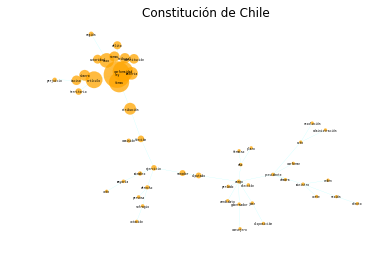

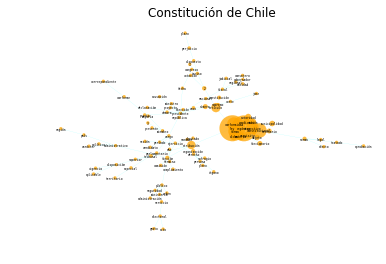

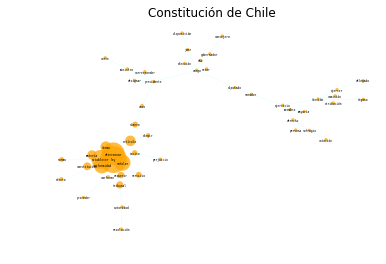

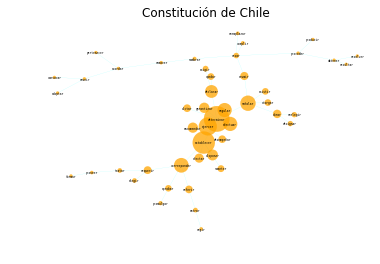

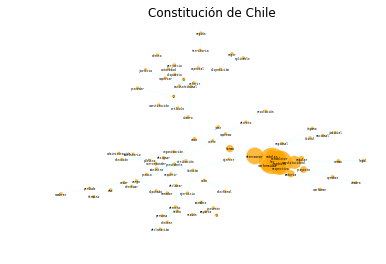

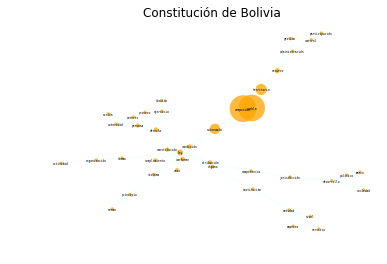

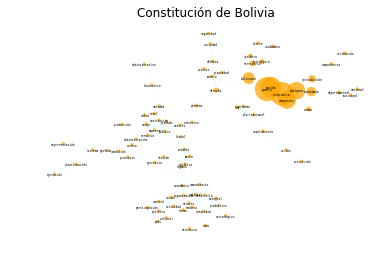

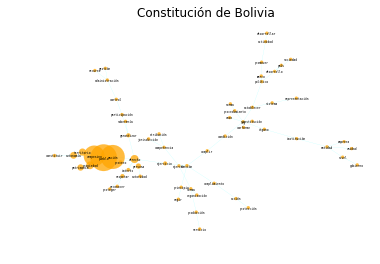

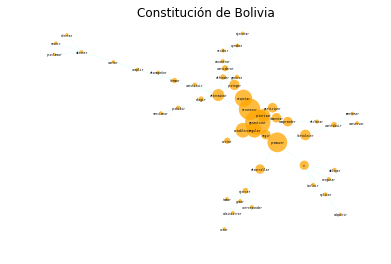

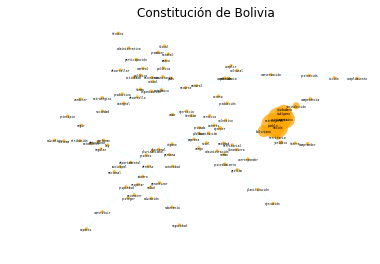

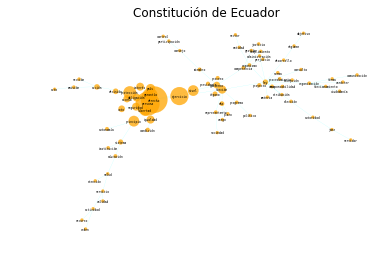

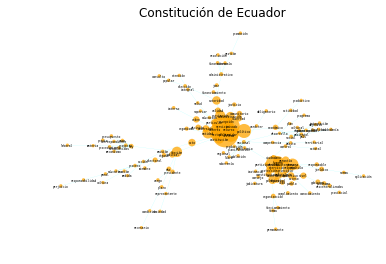

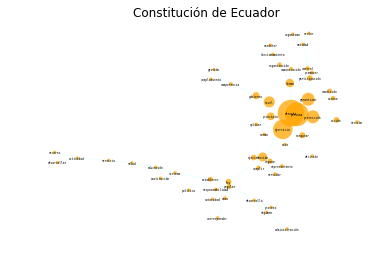

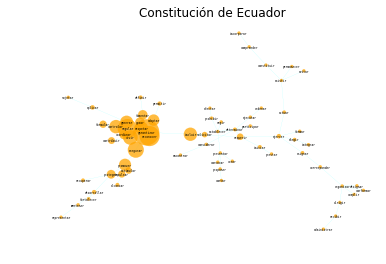

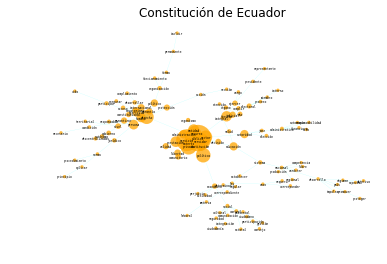

In [23]:
for country_pair in [(chile,'Chile'),(bolivia,'Bolivia'),(ecuador,'Ecuador')]:
    for tag in ['noun','noun_adj','noun_verb','verb','all']:
        G=GoW(clean(country_pair[0],tag))
        plot_graph(G,tag,country_pair[1])